<a href="https://colab.research.google.com/github/MalekRihani/Rag/blob/main/%20multimodal%20fake%20news%20detection%20system%20using%20CLIP%20%2B%20LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import os
import re
import string
from transformers import CLIPProcessor, CLIPModel
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class DataCleaner:
    """Clean data following the paper's methodology"""

    def __init__(self):
        self.stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

    def clean_text(self, text):
        """Clean text following paper methodology"""
        if pd.isna(text):
            return ""

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs and hyperlinks
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

        # Remove punctuation and special characters
        text = re.sub(r'[^\w\s]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Remove stop words
        words = [word for word in text.split() if word not in self.stop_words]

        return ' '.join(words)

    def is_valid_image_url(self, url):
        """Check if image URL is accessible"""
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
            response = requests.head(url, headers=headers, timeout=5)
            return response.status_code == 200
        except:
            return False

    def clean_dataset(self, df, sample_size=30000):
        """Clean dataset following paper methodology"""
        print(f"Original dataset size: {len(df)}")

        # Remove rows with missing critical data
        df_clean = df.dropna(subset=['image_url', 'title']).copy()
        print(f"After removing missing data: {len(df_clean)}")

        # Clean text
        df_clean['title_clean'] = df_clean['title'].apply(self.clean_text)

        # Remove empty titles after cleaning
        df_clean = df_clean[df_clean['title_clean'].str.len() > 10].copy()
        print(f"After text cleaning: {len(df_clean)}")

        # Sample to desired size for efficiency
        if len(df_clean) > sample_size:
            # Maintain class balance
            if '2_way_label' in df_clean.columns:
                fake_samples = df_clean[df_clean['2_way_label'] == 1].sample(n=sample_size//2, random_state=42)
                real_samples = df_clean[df_clean['2_way_label'] == 0].sample(n=sample_size//2, random_state=42)
                df_clean = pd.concat([fake_samples, real_samples]).sample(frac=1, random_state=42).reset_index(drop=True)
            else:
                df_clean = df_clean.sample(n=sample_size, random_state=42).reset_index(drop=True)

        print(f"Final cleaned dataset size: {len(df_clean)}")
        return df_clean

class FakeNewsDataset(Dataset):
    """Efficient dataset with image caching"""

    def __init__(self, df, processor, cache_dir="image_cache"):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def download_image(self, url, idx):
        """Download and cache image"""
        cache_path = os.path.join(self.cache_dir, f"img_{idx}.jpg")

        if os.path.exists(cache_path):
            try:
                return Image.open(cache_path).convert('RGB')
            except:
                pass

        try:
            headers = {'User-Agent': 'Mozilla/5.0'}
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content)).convert('RGB')
            image.save(cache_path)
            return image
        except:
            # Return white dummy image
            dummy = Image.new('RGB', (224, 224), 'white')
            dummy.save(cache_path)
            return dummy


    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Get image
        image = self.download_image(row['image_url'], idx)

        # Get text
        text = row['title_clean'] if 'title_clean' in row else str(row['title'])

        # Process with CLIP
        inputs = self.processor(
            text=[text],
            images=[image],
            return_tensors="pt",
            padding='max_length', # Apply padding here
            truncation=True,
            max_length=77
        )

        # Get label
        label = int(row['2_way_label']) if '2_way_label' in row and pd.notna(row['2_way_label']) else 0

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class CLIPFakeNewsClassifier(nn.Module):
    """CLIP model with QLoRA for fake news detection"""

    def __init__(self, model_name="openai/clip-vit-base-patch32", num_classes=2):
        super().__init__()

        # Load base CLIP model
        base_clip = CLIPModel.from_pretrained(model_name)

        # Get text and vision models
        self.text_model = base_clip.text_model
        self.vision_model = base_clip.vision_model

        # Apply QLoRA to Text Model
        text_lora_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION, # Changed task_type to FEATURE_EXTRACTION
            r=16,
            lora_alpha=32,
            target_modules=["q_proj", "v_proj"], # Target relevant modules in text transformer
            lora_dropout=0.1,
            bias="none"
        )
        self.text_model = get_peft_model(self.text_model, text_lora_config)

        # Apply QLoRA to Vision Model
        vision_lora_config = LoraConfig(
             task_type=TaskType.FEATURE_EXTRACTION, # Use a relevant task type for vision models
            r=16,
            lora_alpha=32,
            target_modules=["q_proj", "v_proj"], # Target relevant modules in vision transformer
            lora_dropout=0.1,
            bias="none"
        )
        self.vision_model = get_peft_model(self.vision_model, vision_lora_config)


        # Classification head
        # Calculate combined feature size based on the output dimensions of the adapted models
        text_output_dim = self.text_model.config.hidden_size
        vision_output_dim = self.vision_model.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(text_output_dim + vision_output_dim, 512), # Combined text + image features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        # Get text embeddings from the LoRA-adapted text model
        # Access the base model directly to avoid unexpected arguments
        text_outputs = self.text_model.base_model.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # Use the last hidden state as text embedding
        text_embeds = text_outputs.last_hidden_state[:, 0, :] # Typically use the embedding of the first token (CLS token)

        # Get image embeddings from the LoRA-adapted vision model
        # Access the base model directly to avoid unexpected arguments
        vision_outputs = self.vision_model.base_model.model(
            pixel_values=pixel_values
        )
        # Use the pooler output or the last hidden state for image embedding
        image_embeds = vision_outputs.pooler_output if vision_outputs.pooler_output is not None else vision_outputs.last_hidden_state[:, 0, :]


        # Concatenate features
        combined_features = torch.cat([text_embeds, image_embeds], dim=1)

        # Classify
        logits = self.classifier(combined_features)

        return logits

class SimpleTrainer:
    """Efficient trainer"""

    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    def train_epoch(self, dataloader, optimizer, criterion):
        self.model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc="Training"):
            optimizer.zero_grad()

            # Move to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            pixel_values = batch['pixel_values'].to(self.device)
            labels = batch['label'].to(self.device)

            # Forward pass
            logits = self.model(input_ids, attention_mask, pixel_values)
            loss = criterion(logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def validate(self, dataloader, criterion):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Validation"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                pixel_values = batch['pixel_values'].to(self.device)
                labels = batch['label'].to(self.device)

                logits = self.model(input_ids, attention_mask, pixel_values)
                loss = criterion(logits, labels)

                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_preds)

        return avg_loss, accuracy, all_preds, all_labels

    def train(self, train_loader, val_loader, epochs=5, lr=1e-4):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        best_acc = 0

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Train
            train_loss = self.train_epoch(train_loader, optimizer, criterion)

            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate(val_loader, criterion)

            # Update scheduler
            scheduler.step()

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Save best model
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(self.model.state_dict(), 'best_clip_model.pth')
                print(f"✓ Best model saved! Accuracy: {val_acc:.4f}")

        return val_preds, val_labels


    def plot_history(self):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        epochs = range(1, len(self.history['train_loss']) + 1)

        ax1.plot(epochs, self.history['train_loss'], 'b-', label='Train Loss')
        ax1.plot(epochs, self.history['val_loss'], 'r-', label='Val Loss')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(epochs, self.history['val_acc'], 'g-', label='Val Accuracy')
        ax2.set_title('Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
def evaluate_model(y_true, y_pred):
    """Evaluate model performance"""
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [23]:
def main():
    """Main execution"""
    print("🚀 CLIP + QLoRA Fake News Detection")
    print("="*50)

    # Initialize data cleaner
    cleaner = DataCleaner()

    # Load and clean data
    print("📊 Loading and cleaning datasets...")
    train_df = pd.read_csv("/content/multimodal_train.tsv", sep="\t")
    val_df = pd.read_csv("/content/multimodal_validate.tsv", sep="\t")
    test_df = pd.read_csv("/content/multimodal_test_public.tsv", sep="\t")

    # Clean datasets
    train_clean = cleaner.clean_dataset(train_df, sample_size=20000)
    val_clean = cleaner.clean_dataset(val_df, sample_size=4000)
    test_clean = cleaner.clean_dataset(test_df, sample_size=6000)

    print(f"📈 Label distribution in training set:")
    if '2_way_label' in train_clean.columns:
        print(train_clean['2_way_label'].value_counts())

    # Initialize CLIP processor
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    # Create datasets
    train_dataset = FakeNewsDataset(train_clean, processor, "train_cache")
    val_dataset = FakeNewsDataset(val_clean, processor, "val_cache")
    test_dataset = FakeNewsDataset(test_clean, processor, "test_cache")

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    print(f"🔧 Training batches: {len(train_loader)}")
    print(f"🔧 Validation batches: {len(val_loader)}")

    # Initialize model
    model = CLIPFakeNewsClassifier()

    # Print trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Total parameters: {total_params:,}")
    print(f"📊 Trainable parameters: {trainable_params:,}")
    print(f"📊 Trainable %: {100 * trainable_params / total_params:.2f}%")

    # Train model
    trainer = SimpleTrainer(model)
    print("\n🎯 Starting training...")

    val_preds, val_labels = trainer.train(
        train_loader,
        val_loader,
        epochs=5,
        lr=1e-4
    )

    # Plot training history
    trainer.plot_history()

    # Evaluate
    evaluate_model(val_labels, val_preds)

    # Test predictions
    print("\n🔮 Making test predictions...")
    test_loss, test_acc, test_preds, test_labels = trainer.validate(test_loader, nn.CrossEntropyLoss())

    # Save results
    results_df = test_clean.copy()
    results_df['prediction'] = test_preds
    results_df.to_csv('test_predictions.csv', index=False)

    print(f"\n✅ Training completed!")
    print(f"📈 Best validation accuracy: {max(trainer.history['val_acc']):.4f}")
    print(f"💾 Results saved to 'test_predictions.csv'")



🚀 CLIP + QLoRA Fake News Detection
📊 Loading and cleaning datasets...
Original dataset size: 564000
After removing missing data: 562466
After text cleaning: 508176
Final cleaned dataset size: 20000
Original dataset size: 59342
After removing missing data: 59169
After text cleaning: 53394
Final cleaned dataset size: 4000
Original dataset size: 59319
After removing missing data: 59163
After text cleaning: 53338
Final cleaned dataset size: 6000
📈 Label distribution in training set:
2_way_label
0    10000
1    10000
Name: count, dtype: int64
🔧 Training batches: 1250
🔧 Validation batches: 250
📊 Total parameters: 152,261,890
📊 Trainable parameters: 1,639,938
📊 Trainable %: 1.08%

🎯 Starting training...

Epoch 1/5


Validation: 100%|██████████| 250/250 [10:04<00:00,  2.42s/it]


Train Loss: 0.4137
Val Loss: 0.3552, Val Acc: 0.8387
✓ Best model saved! Accuracy: 0.8387

Epoch 2/5


Validation: 100%|██████████| 250/250 [00:53<00:00,  4.65it/s]


Train Loss: 0.3220
Val Loss: 0.3485, Val Acc: 0.8492
✓ Best model saved! Accuracy: 0.8492

Epoch 3/5


Validation: 100%|██████████| 250/250 [00:51<00:00,  4.84it/s]


Train Loss: 0.2512
Val Loss: 0.3916, Val Acc: 0.8430

Epoch 4/5


Validation: 100%|██████████| 250/250 [00:53<00:00,  4.67it/s]


Train Loss: 0.1892
Val Loss: 0.5444, Val Acc: 0.8420

Epoch 5/5


Validation: 100%|██████████| 250/250 [00:54<00:00,  4.62it/s]


Train Loss: 0.1478
Val Loss: 0.6170, Val Acc: 0.8370


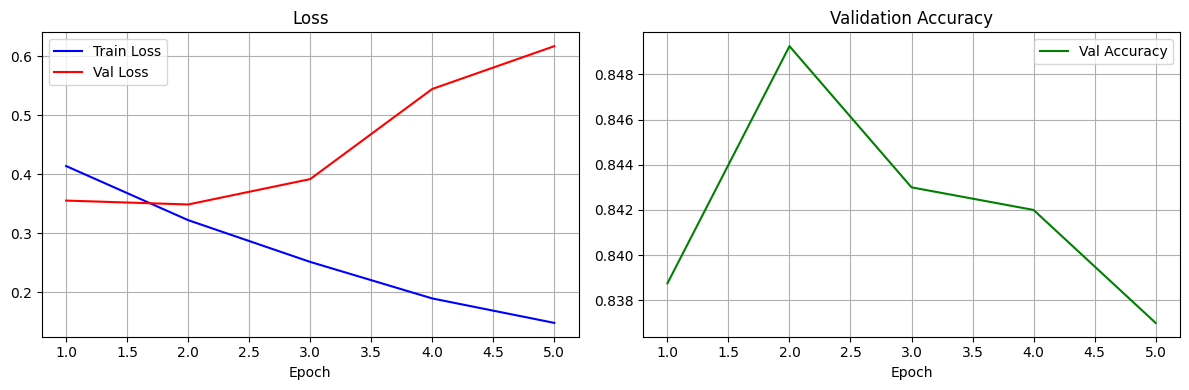


EVALUATION RESULTS
Accuracy: 0.8370

Classification Report:
              precision    recall  f1-score   support

        Real       0.86      0.80      0.83      2000
        Fake       0.82      0.87      0.84      2000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



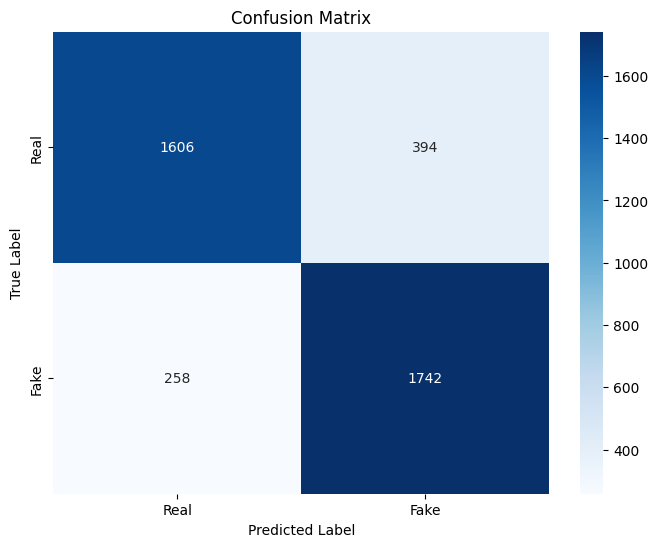


🔮 Making test predictions...


Validation:  30%|███       | 113/375 [04:25<10:59,  2.52s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x787774602de0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Validation:  35%|███▍      | 131/375 [05:04<07:19,  1.80s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x787774602de0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __d


✅ Training completed!
📈 Best validation accuracy: 0.8492
💾 Results saved to 'test_predictions.csv'


In [22]:
main()